## Simulate x-ray reflection data

###### Import atomic scattering factors.

In [3]:
import cmath
import os
import pandas as pd
import numpy as np
import math
%run tools.ipynb

In [4]:
#Sr_scattering_factor = pd.read_csv("../Atomic/sr.txt", header = None, sep = ' ')
Sr_scattering_factor = pd.read_csv("sr.txt", sep = '\t', index_col= False)
Sr_scattering_factor.columns = ['E(ev)', 'f1', 'f2']
#Sr_scattering_factor = pd.read_csv(os.path.join(os.path.dirname(os.path.realpath('__file__')), "/Atomic/sr.txt"))
Ti_scattering_factor = pd.read_csv("ti.txt", sep = '\t', index_col= False)
Ti_scattering_factor.columns = ['E(ev)', 'f1', 'f2']

# loading O scattering factor
O_scattering_factor = pd.read_csv("o.txt", sep = '\t', index_col= False)
O_scattering_factor.columns = ['E(ev)', 'f1', 'f2']

# loading Ru scattering factor
Ru_scattering_factor = pd.read_csv("ru.txt", sep = '\t', index_col= False)
Ru_scattering_factor.columns = ['E(ev)', 'f1', 'f2']

# loading Si scattering factor
Si_scattering_factor = pd.read_csv("si.txt", sep = '\t', index_col= False)
Si_scattering_factor.columns = ['E(ev)', 'f1', 'f2']

In [5]:
# We load the scattering factor for the elements into a dictionary. 
scattering_factor_dict = {}
scattering_factor_dict['sr'] = Sr_scattering_factor
scattering_factor_dict['ti'] = Ti_scattering_factor
scattering_factor_dict['o'] = O_scattering_factor
scattering_factor_dict['ru'] = Ru_scattering_factor
scattering_factor_dict['si'] = Si_scattering_factor

In [6]:
# We load the element mass into the atomic mass dictionary
atomic_mass_dict = {}
atomic_mass_dict['sr'] = 87.62
atomic_mass_dict['ti'] = 47.87
atomic_mass_dict['o'] = 16.00
atomic_mass_dict['ru'] = 101.07
atomic_mass_dict['si'] = 28.09

###### Calculate the x-ray scattering length density

In [102]:
class xrrFit:
    def __init__(self, scattering_factor_dict, atomic_mass_dict, layer):
        """
        scattering_factor_dict is the dict for atomic scattering factor
        atomic_mass_dict is the dict for atomic mass
        self.scattering_factor is a dict that stores the scattering factor of each element.
        self.scattering_length is a dict that stores the scattering length of each element. 
        
        layer is the input layered structure, which is a dictionary. For example, SrRuO3/SrTiO3, the input is 
        {1: [('sr', 1), ('ti', 1), ('o', 3)], 2: [('sr', 1), ('ru', 1), ('o', 3)]}
        The 0th layer is always the vacuum. 
        
        
        """
        self.xray_wavelength = 1.54059 * 10 ** (-10) # The unit of the xray_wavelength is m
        self.xray_energy = 0 # in the unit of ev.
        self.scattering_factor_dict = scattering_factor_dict
        self.atomic_mass_dict = atomic_mass_dict
        self.scattering_factor = {}
        self.scattering_length = {}
        self.layer = layer
        self.num_of_layer = len(layer)
        
        
    def get_scattering_factor(self, element, element_sf):
        """
        get the atomic scattering factor corresponding to the xray_wavelength
        element is a string representing the element. element_sf is a dataframe containing the scattering factor.
        I think f1 is dimensionless
        """
        # calculate f1, which is the real part of the atomic scattering factor. We assume that the energy of the x-ray 
        # is within the range in the element_sf dataframe. Note that the atomic scattering factor is fixed for each
        # element.
    
        # We locate the nearest energy in the column element_sf['E(ev)'] corresponding to the xray_energy 
        #import bisect
    
        self.xray_energy = cal_xray_energy(self.xray_wavelength) * 1000 # xray_energy is in the unit of ev. 
        import bisect
        pos = bisect.bisect_left(element_sf['E(ev)'].tolist(), self.xray_energy)
        # Use linear extrapolation to get f1 corresponding to the xray_energy
        f1 = (element_sf.iloc[pos]['f1'] - element_sf.iloc[pos + 1]['f1']) / \
            (element_sf.iloc[pos]['E(ev)'] - element_sf.iloc[pos + 1]['E(ev)']) * \
            (self.xray_energy - element_sf.iloc[pos]['E(ev)']) + element_sf.iloc[pos]['f1']
        self.scattering_factor[element] = f1
        return f1 
    
    def cal_scattering_length(self, element, element_sf):
        """
        element_sf is the dataframe containing the x-ray scattering factor
        The program return (b_i in the above equation) has a unit of m. 
        bi is also element dependent and is not affected by the density.
        """
        planck_const = 6.62 * 10 ** (-34) # The unit of planck constant is (m^2 kg) / s
        c = 2.998 * 10 ** 8
        e = 1.60 * 10 ** (-19)
        epsilon_0 = 8.85 * 10 ** (-12)
        me = 9.11 * 10 ** (-31)
    
        f1 = self.scattering_factor[element]
        prefactor = e * e / (4 * cmath.pi * epsilon_0 * me * c * c)
        #print(prefactor)
        bi = prefactor * f1
        self.scattering_length[element] = bi
        return bi
    
    def cal_SLD(self, chem_formula, density):
        """
        chem_formula is the chemical formula of the material. For example, 
        SrTiO3 will be [('sr', 1), ('ti', 1), ('o', 3)].
        density (float) if the bulk density of the material, in the unit of g/cm^3. 
        The returned value is in the unit of Å^(-2).
        Note that the parameter density should be varied to find the best fit. 
        """
        SLD = 0
        Na = 6.02 * 10 ** 23
        M = 0
        b_total = 0
        for elem in chem_formula:
            M += self.atomic_mass_dict[elem[0]] * elem[1]
            b_total += self.scattering_length[elem[0]] * elem[1]
        #print(M)
        SLD = density * Na * b_total / M * (10 ** (-14))  # convert the unit to Å^(-2)
        return SLD
    
    def cal_refractive_index(self, chem_formula, density):
        """
        calculate the refractive index for the input material. Here we ignore the absorption part beta_j.
        """
        SLD = self.cal_SLD(chem_formula, density)
        delta_j = ((self.xray_wavelength * 10 ** 10) ** 2) / (2 * cmath.pi) * SLD
        N_j = 1 - delta_j
        return N_j
    
    def cal_Q(self, theta, density):
        """
        calculate Q_j according to the formula give in v2. 
        
        density is a dict which corresponds to each layer's density (in the unit of g/cm^3): {1: 4.81, 2: 6.2}.
        The returned value is a list of values of [Q_0, Q_1, Q_2, ... , Q_L], in the unit of Å^(-1).
        """
        Q_vec = [0 for j in range(self.num_of_layer + 1)]
        Q0 = (4 * math.pi * math.sin(theta / 180 * math.pi)) / (self.xray_wavelength * 10 ** 10)
        Q_vec[0] = Q0
        for j in self.layer:
            rho_j = self.cal_SLD(self.layer[j], density[j])
            Q_j = math.sqrt((Q0 * Q0 - 16 * math.pi * rho_j))
            Q_vec[j] = Q_j
        return Q_vec 
    
    def cal_reflec_Intensity_Parratt(self, theta, input_vec):
        """
        calculate the reflection intensity for a given theta angle (in unit of °).
        input_vec is the input vector that is used to calculate the simulated xrr intensity. For example, the input 
        vector can be input_vec = [10 ** 6, 10, 4.8, 6.2, 150, float('inf'), 4, 1]. input_vec[0] is the number of 
        layers. The input_vec is of numpy.array type.
        Note that for density and thickness, the dict is like {1: , 2:}; for roughness, the dict is like {0: , 1:}.
        The unit for density is g/cm^3, for thickness is Å.
        """
        # We split the input input_vec into the physical quantities.
        #num_layers = int(input_vec[0])
        incident_I = input_vec[0]
        backgr_I = input_vec[1]
        density = {i + 1:input_vec[i + 2] for i in range(self.num_of_layer)}
        thickness = {i + 1:input_vec[i + 2 + self.num_of_layer] for i in range(self.num_of_layer)}
        roughness = {i:input_vec[i + 2 + 2 * self.num_of_layer] for i in range(self.num_of_layer)}
        #print(density, thickness, roughness)
    
        Q_vec = self.cal_Q(theta, density)
        r_vec = [0 for _ in range(len(Q_vec) - 1)] # r_vec[i] is the quantity r_{i, i + 1}. 
        for i in range(len(r_vec)):
            r_vec[i] = (Q_vec[i] - Q_vec[i + 1]) / (Q_vec[i] + Q_vec[i + 1]) \
                        * math.exp(-2 * (Q_vec[i] / 2) * (Q_vec[i + 1] / 2) * roughness[i] ** 2)
        # X_vec is the X vector. [X_0, X_1, ..., X_L]. Here X_L = 0, which is the bottom most layer. 
        X_vec = [0 for _ in range(len(Q_vec))]
        phi_vec = [0 for _ in range(len(Q_vec))]
        # Calculate the phase vector phi_vec = [\phi_0, \phi_1, ... , \phi_L]. As the substrate's thickness is assumed 
        # to be infinite, so we don't calculate \phi_L. We directly set \phi_L = 0. Also, in the following loop, we don't
        # update phi_vec[0], which means we leave phi_vec[0] = 0. 
        
    
        # We start from the bottom most layer, and compute upwards until we reach the first layer (layer 0). 
        for j in range(len(r_vec) - 1, -1, -1):
            if j + 1 == self.num_of_layer:
                phi_vec[j + 1] = 0
            else:
                phi_vec[j + 1] = cmath.exp(1j * Q_vec[j + 1] / 2 * thickness[j + 1])
            X_vec[j] = (r_vec[j] + X_vec[j + 1] * (phi_vec[j + 1]) ** 2) \
                        / (1 + r_vec[j] * X_vec[j + 1] * (phi_vec[j + 1]) ** 2)
        return incident_I * np.absolute(X_vec[0]) ** 2 + backgr_I
    
    def error_total(self, theta_measured, inten_measured, para_vec):
        """
        calculate the total error for the simulated intensity and the measured data.
        """
        n = len(theta_measured)
        error = 0
        for i in range(n):
            calculated_intensity = self.cal_reflec_Intensity_Parratt(theta_measured[i], para_vec)
            error += abs(math.log(inten_measured[i]) - math.log(calculated_intensity))
        return error / (n - 1)

We calculate the x-ray scattering lenght according to $\displaystyle b_i = \frac{e^2 }{4\pi \epsilon_0 m_e c^2} f_1 $. Refer to [this link](http://gisaxs.com/index.php/Scattering_Length_Density).

We calculate the scattering length density using $\displaystyle SLD = \frac{\sum_{i = 1}^N b_i}{V_m} $, where $\displaystyle V_m = \frac{M}{\rho N_a}$. Here $ \rho$ is the bulk density of the material, and $M$ is the molecular weight. $N_a$ is the Avogadro constant. Plug this in, we have $\displaystyle SLD = \frac{\rho N_a \sum_{i = 1}^N b_i}{\sum_{i = 1}^N M_i} $, where $M_i$ is the atomic molar mass for each element.  Refer to [this link](http://gisaxs.com/index.php/Scattering_Length_Density).

Note that $N_j = 1 - \delta_j + i \beta_j$. We use $\displaystyle \delta_j = (\lambda^2 / 2 \pi ) \rho_j$ to calculate the $\delta_j$ in the refractive index $N_j$. Here $ \rho_j$ is the scattering length density (SLD).

We calculate $\displaystyle Q_j = (Q^2 - 16 \pi \rho_j)^{1 / 2} $. Here $\displaystyle Q = Q_0 = \frac{4 \pi \sin \theta_0}{\lambda_0} $. Here $ \rho_j$ is the scattering length density (SLD). $\theta_0$ is the incident angle between the incident beam and the surface. 

We use the formula $\displaystyle r = r_{0, 1} \prod_j \left[ 1 + f_j \exp (-i Q_j d_j) \right] $, where $\displaystyle f_j = r_{j, \, j + 1} / r_{j - 1, \, j}$ to calculate the reflection term. This is Eqn. (10) in the paper Analysis of Neutron and X-ray Reflectivity Data. I. Theory. For the term $r_{j, \, j + 1}$, we use $\displaystyle r_{j, \, j + 1} = \frac{Q_j - Q_{j + 1}}{Q_j + Q_{j + 1}} $.

##### We next include the surface roughness into the calculation of the reflectivity. 

According to the tutorial note (X-Ray and Neutron Reflectivity for the Investigation of Thin Films – A Short Tutorial –), the roughness effect is taken into consideration through the Fresnel coefficient. We include a term $\displaystyle e^{-2 k_{z, \, j} k_{z, \, j + 1} \sigma^2_{j, \, j + 1}} $ in the Fresnel coefficient. To be consistent with the definitions above, we include a term $\displaystyle e^{-2 Q_{ j} Q_{ j + 1} \sigma^2} $ in the Fresnel coefficient. 

#### Use the evolutionary algorithm to find the optimal parameters

The meaning of the input parameters are as follows: <br>
\[number of layers, Incident intensity, background intensity, density of layer 1, dentsity of layer 2, thickness of layer 1, thickness of layer 2, roughness of interface between layer 0 and layer 1, roughtness of the interface between layer 1 and layer 2 \]. For the substrate thickness, we use float('inf'). Note that actually we will not use the substrate thickness in the calculation. 

We use the Parratt's method. $\displaystyle X_j = \frac{r_j + X_{j + 1} \phi_{j + 1}^2 }{1 + r_j X_{j + 1} \phi_{j + 1}^2}$. Here $\displaystyle r_j = \frac{Q_j - Q_{j + 1}}{Q_j + Q_{j + 1}}$, which is the $\displaystyle r_{j, \, j + 1}$ term above. $\displaystyle \phi_j = \exp(i k_{z, \, j} t_j)$

#### Create the model and xrrFit class.

In [177]:
# Read the measured xrr data.
data_measured = pd.read_csv("ZW723B_10nmSrTiO3_Si_330C_xrr.csv", skiprows= 33, header = None)
data_measured.columns = ['2Theta', 'Intensity']
theta_measured = data_measured['2Theta'].values / 2
inten_measured = data_measured['Intensity'].values
# We don't use the theta_measured data that is smaller than 0.4. 
theta_measured_cutoff = theta_measured[theta_measured > 0.5]
inten_measured_cutoff = inten_measured[theta_measured > 0.5]

In [178]:
#layer = {1: [('sr', 1), ('ru', 1), ('o', 3)], 2: [('sr', 1), ('ti', 1), ('o', 3)]}
layer = {1: [('sr', 1), ('ti', 1), ('o', 3)], 2: [('si', 1)]}
input_vec = np.array([10 ** 6, 10, 4.8, 2.3, 100, float('inf'), 4, 1])

In [179]:
xrrfit = xrrFit(scattering_factor_dict=scattering_factor_dict, atomic_mass_dict=atomic_mass_dict, layer=layer)
for each_l, chem_formu in layer.items():
    for elem in chem_formu:
        xrrfit.get_scattering_factor(elem[0], scattering_factor_dict[elem[0]])
        xrrfit.cal_scattering_length(elem[0], scattering_factor_dict[elem[0]])
xrrfit.error_total(theta_measured_cutoff, inten_measured_cutoff, input_vec)
#print(xrrfit.cal_Q(1, {1: 4.8, 2:6.2}))
#xrrfit.num_of_layer
#print(xrrfit.layer)

0.7869029088098479

In [183]:
error_each_para

[0.17896135704428193,
 0.17985124328608915,
 0.18157466370532355,
 0.1840002070323743,
 0.18088238929608424,
 0.18267207014544376,
 0.18049524658241492,
 0.17964488198735076,
 0.1815742573476136,
 0.17668503496653684,
 0.17528090722893752,
 0.18065406489509173,
 0.17754837246826677,
 0.1800267492794413,
 0.18220828514625875,
 0.1804282711231683,
 0.18028421590885652,
 0.18401063101129495,
 0.1765911823776895,
 0.18158514800397002,
 0.18480908043579014,
 0.18379525890137013,
 0.18211889731393496,
 0.1815711327847527,
 0.18155960572298613,
 0.18037703978875985,
 0.1819202156383268,
 0.180312978430199,
 0.18297424199300957,
 0.18012112000978747,
 0.1782673091503675,
 0.18099981011872793,
 0.18131316382252308,
 0.18022987268458815,
 0.1839024440449663,
 0.18265017368887412,
 0.18315735317070497,
 0.17886222682304975,
 0.1823233369652608,
 0.18067281430816592,
 0.18250329397565943,
 0.17860689966256807,
 0.18478604804598062,
 0.1794532064046491,
 0.1799526693338774,
 0.18249186739179024,
 0

##### generate inital M parameter vectors. 

In [180]:
num_para = len(input_vec)
M = 10 * num_para
initial_rou_SrTiO3 = 4.8
initial_rou_SrRuO3 = 6.2
initial_rou_Si = 2.32
thickness_range = [50, 100]
# For each parameter's interval [a, b] in the rand_input_vec, 
# its lower limit is a and its upper limit is b. 
rand_input_vec = [[10**5, 9 * 10**5], [1, 99], [initial_rou_SrTiO3 / 2, initial_rou_SrTiO3], \
                 [initial_rou_Si / 2, initial_rou_Si], thickness_range, [float('inf'), float('inf')], \
                  [1, 10], [0, 2]]

In [181]:
initial_M_para_vec = np.zeros(shape = (M, num_para))
for i in range(M):
    temp = np.zeros(shape = (num_para, ))
    for j in range(num_para):
        temp[j] = rand_input_vec[j][0] + np.random.uniform() * rand_input_vec[j][1]
    #initial_M_para_vec.append(temp)
    initial_M_para_vec[i] = temp
initial_M_para_vec[0] = input_vec

#### Define the error funtion. We use $\displaystyle E(p) = \frac{1}{N - 1} \sum_{i = 1}^{N} | \log I_j - \log I(\theta_j; \, p) |$

#### We use the differential evolutionary algorithm to find the best fit. 

In [182]:
num_iteration = 100
best_para_vec = np.zeros(shape = (num_para, ))
mutation_const = 0.7
recombi_const = 0.5
cur_best_error = float('inf')
#initialize the best parameter vector
error_each_para = [0 for _ in range(M)]
for i in range(M):
    cur = xrrfit.error_total(theta_measured_cutoff, inten_measured_cutoff, initial_M_para_vec[i])
    error_each_para[i] = cur
    if cur < cur_best_error:
        best_error_idx = i
        cur_best_error = cur
best_para_vec = initial_M_para_vec[best_error_idx]
for i in range(num_iteration):
    print(i, end='')
    for j in range(M):
        a = np.random.randint(M)
        while True:
            b = np.random.randint(M)
            if b != a:
                break
        b_vec_prime = best_para_vec + (initial_M_para_vec[a] - initial_M_para_vec[b]) * mutation_const
        trial_t_vec = np.zeros(shape = (num_para, ))
        pos = np.random.randint(num_para)
        cnt = 0
        for k in range(num_para):
            if k == num_para - 1:
                trial_t_vec[pos] = b_vec_prime[pos]
            else:
                c = np.random.uniform()
                if c <= 0.5:
                    trial_t_vec[pos] = b_vec_prime[pos]
                else:
                    trial_t_vec[pos] = initial_M_para_vec[j][pos]
            #if trial_t_vec[pos] == float('inf'):
            #    continue
            if trial_t_vec[pos] != float('inf') and (trial_t_vec[pos] < rand_input_vec[pos][0] or \
                    trial_t_vec[pos] > rand_input_vec[pos][0] + rand_input_vec[pos][1]):
                trial_t_vec[pos] = rand_input_vec[pos][0] + np.random.uniform() * rand_input_vec[pos][1]
            pos = (pos + 1) % num_para
        #olderror_j = xrrfit.error_total(theta_measured_cutoff, inten_measured_cutoff, initial_M_para_vec[j])
        #print(trial_t_vec)
        trialerror_j = xrrfit.error_total(theta_measured_cutoff, inten_measured_cutoff, trial_t_vec)
        #if trialerror_j < olderror_j:
        if trialerror_j < error_each_para[j]:
            initial_M_para_vec[j] = trial_t_vec
            error_each_para[j] = trialerror_j
            
        
    
    
    

0

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in subtract


123456789101112131415161718192021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899

In [184]:
error_each_para.index(min(error_each_para))

10

In [185]:
initial_M_para_vec[10]

array([  9.20641845e+05,   2.15938874e+01,   5.62931276e+00,
         2.66102965e+00,   9.43826282e+01,              nan,
         2.20438209e+00,   4.01780119e-01])

##### Plot the simulated reflection intensity as a function of the indident angle theta. 

In [186]:
reflec_Intensity_simul = np.zeros(shape = (len(theta_measured_cutoff), ))
for i in range(len(reflec_Intensity_simul)):
    reflec_Intensity_simul[i] = xrrfit.cal_reflec_Intensity_Parratt(theta_measured_cutoff[i], 
                                                                    initial_M_para_vec[10])

In [187]:
len(theta_measured_cutoff)

2000

##### Plot both the simulated XRR curve and the measured curve,  taking the surface roughness into consideration.

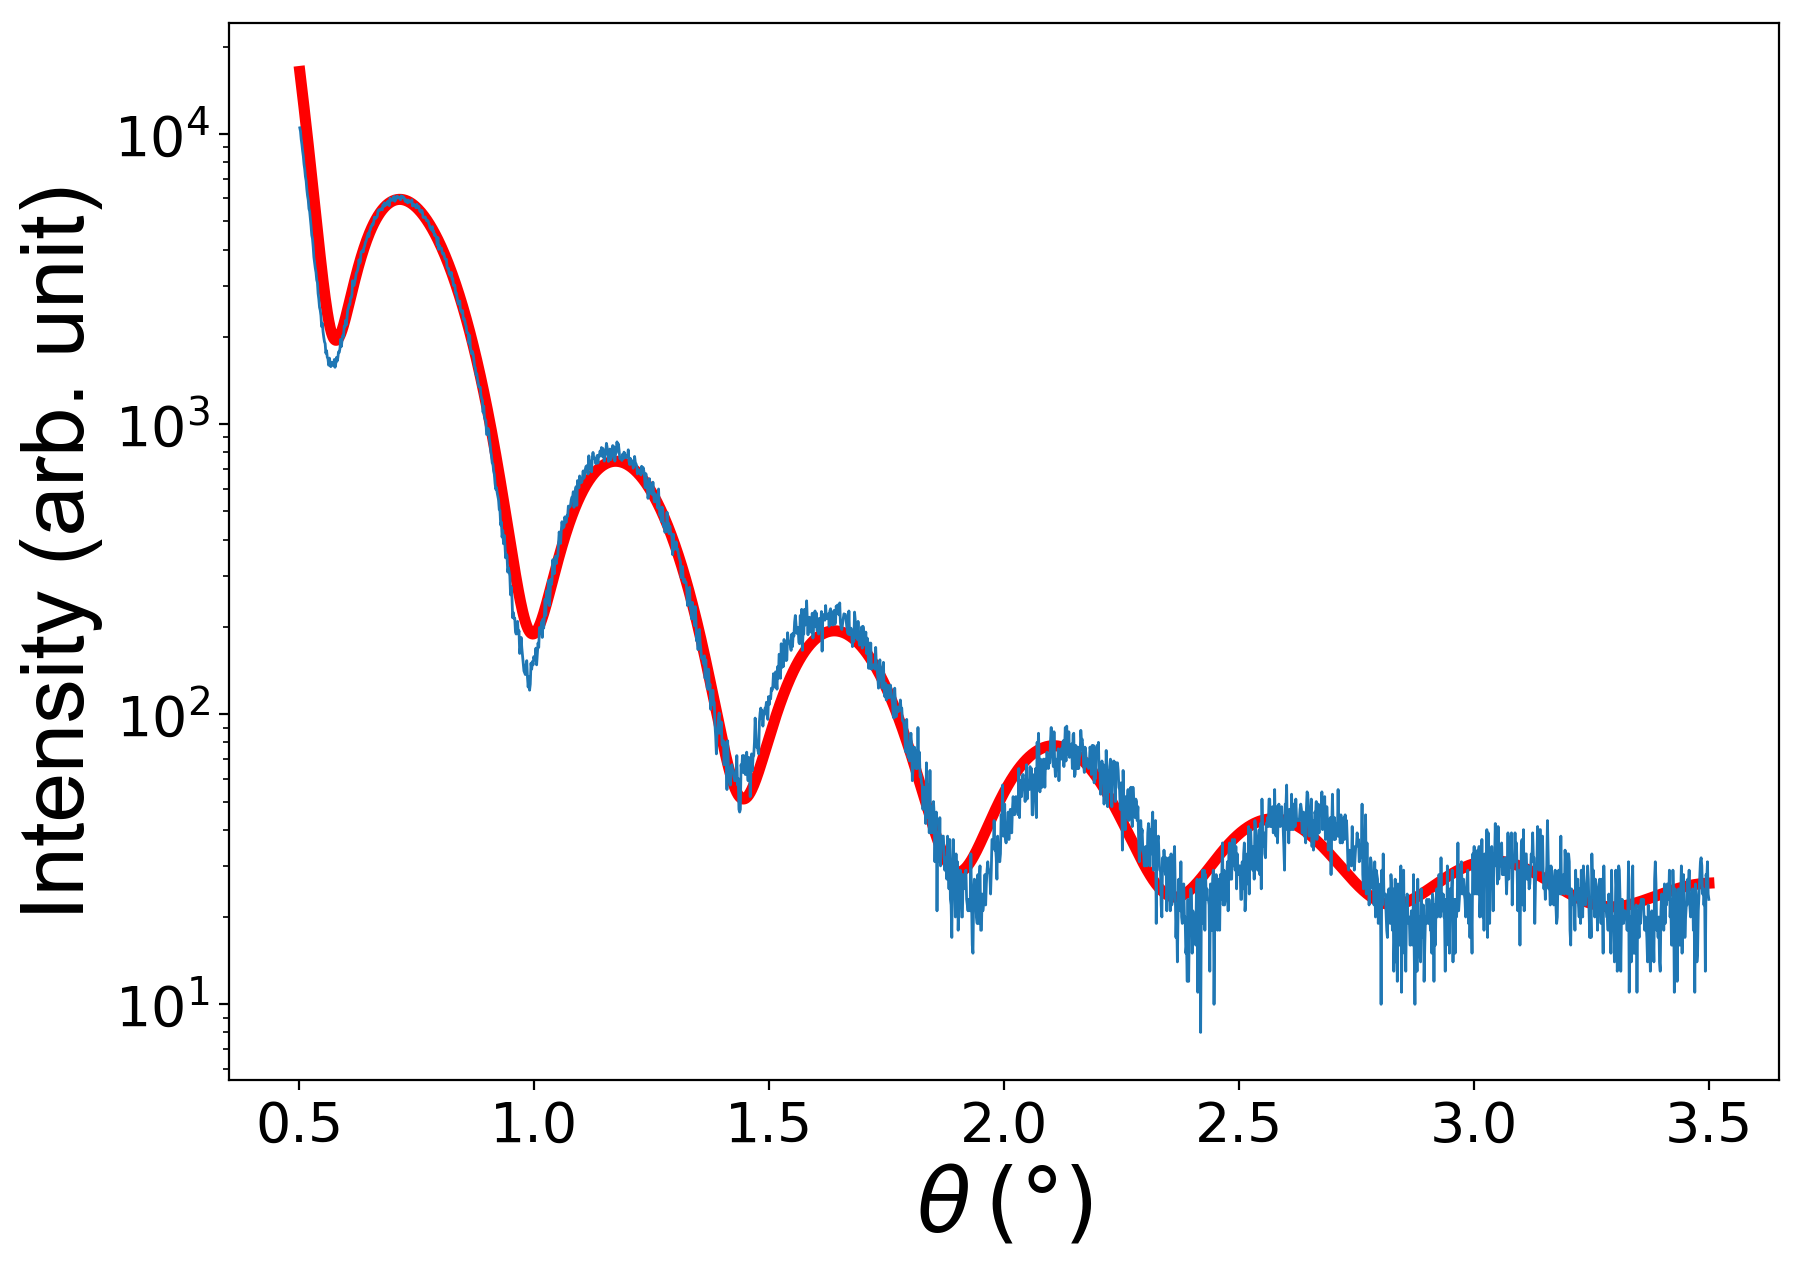

In [196]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(10,7), dpi = 200)
plt.semilogy(theta_measured_cutoff, reflec_Intensity_simul, '-', linewidth = 4, color = 'red')
plt.semilogy(theta_measured_cutoff, inten_measured_cutoff, linewidth = 1)
plt.xlabel(r'$\theta \, (°) $', fontsize = 32, family = 'Arial')
plt.ylabel('Intensity (arb. unit)', fontsize = 32, family = 'Arial')
plt.tick_params(labelsize = 20)

##### Plot both the simulated XRR curve and the measured curve,  taking the surface roughness into consideration.

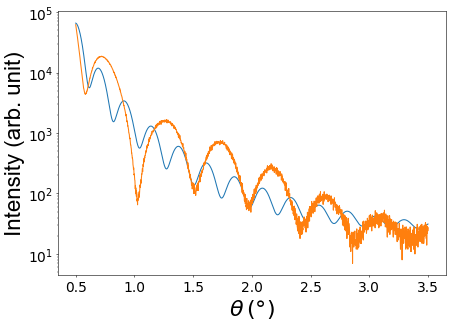

In [65]:
figure(figsize=(10,7), dpi = 50)
plt.semilogy(theta_measured_cutoff, reflec_Intensity_simul, theta_measured_cutoff, inten_measured_cutoff)
plt.xlabel(r'$\theta \, (°) $', fontsize = 32, family = 'Arial')
plt.ylabel('Intensity (arb. unit)', fontsize = 32, family = 'Arial')
plt.tick_params(labelsize = 20)

##### We next include the surface roughness into the calculation of the reflectivity. 

We compare the different reflectivity intensity corresponding to different film roughness. 

In [64]:
roughness = [1, 2, 3, 4] # Suppose we have a list of different roughness. The unit of roughness is Å. 

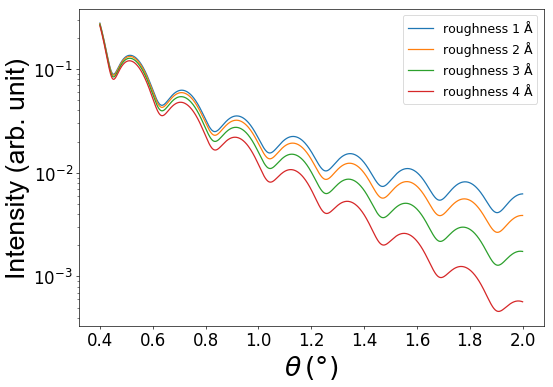

In [68]:
figure(figsize=(10,7), dpi = 60)
for k in range(len(roughness)):
    temp = [0 for _ in range(len(theta))]
    for i in range(len(theta)):
        temp[i] = cal_reflec_Intensity(theta[i], scattering_factor_dict, atomic_mass_dict, layer, thickness, \
                                      roughness = roughness[k])
    temp = np.array(temp)
    plt.semilogy(theta, temp)
plt.xlabel(r'$\theta \, (°) $', fontsize = 32, family = 'Arial')
plt.ylabel('Intensity (arb. unit)', fontsize = 32, family = 'Arial')
plt.tick_params(labelsize = 20)
plt.legend(('roughness 1 Å', 'roughness 2 Å', 'roughness 3 Å', 'roughness 4 Å'),
           loc='upper right', fontsize = 15)